In [1]:
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
# фиксируем для воспроизводимости
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
# Путь на локальной машине, ссылка на исходный датасет указана в ReadMe
root = r'C:\\Users\\Maxim\\Downloads\\archive\\AdienceBenchmarkGenderAndAgeClassification\\' 
total_data = pd.DataFrame()

In [3]:
for i in range(5):
    data = pd.read_csv(root+'fold_{}_data.txt'.format(i), sep = '\t') # Параметры и лейблы помещены в 5 отдельных txt-файлов, собираем их в один
    total_data = total_data.append(data)

In [4]:
total_data.describe()

,face_id,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
count,19370.000000,19370.000000,19370.000000,19370.000000,19370.000000,19370.000000,19370.000000,19370.000000
mean,1023.858906,949.670212,675.659370,633.042437,629.692463,-12.405111,3.128549,72.266598
std,645.385251,667.060150,429.918002,440.409036,426.296233,73.430214,15.658667,38.799247
min,1.000000,0.000000,0.000000,80.000000,80.000000,-205.000000,-45.000000,5.000000
25%,486.000000,441.250000,333.000000,324.000000,325.000000,-80.000000,0.000000,42.000000
50%,980.000000,852.000000,653.000000,517.000000,517.000000,-5.000000,0.000000,70.000000
75%,1526.000000,1359.000000,964.000000,778.000000,778.000000,5.000000,0.000000,98.000000
max,2284.000000,10024.000000,2752.000000,3264.000000,3225.000000,365.000000,45.000000,221.000000


In [5]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [6]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19370 entries, 0 to 3815
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.9+ MB


In [7]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19370 entries, 0 to 3815
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
 2   x       19370 non-null  int64 
 3   y       19370 non-null  int64 
 4   dx      19370 non-null  int64 
 5   dy      19370 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.0+ MB


In [8]:
df = df.reset_index()

In [9]:
img_path = []
for row in total_data.iterrows():
    path = 'C:\\Users\\Maxim\\Downloads\\archive\\AdienceBenchmarkGenderAndAgeClassification\\'+'faces\\'+row[1].user_id+'\\coarse_tilt_aligned_face.'+str(row[1].face_id)+'.'+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path # добавляем в датафрейм пути к файлам картинок

In [10]:
# формируем возрастные группы
age_mapping = [('(0, 2)', '0-3'), ('2', '0-3'), ('3', '0-3'), ('(4, 6)', '4-6'), 
               ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-22'), ('(8, 23)','15-22'), 
               ('23', '25-33'), ('(15, 20)', '15-22'), ('(25, 32)', '25-33'),
               ('(27, 32)', '25-33'), ('32', '25-33'), ('34', '25-33'), ('29', '25-33'), 
               ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '38-43'), 
               ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), 
               ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), 
               ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

In [11]:
age_mapping_dict = {each[0]: each[1] for each in age_mapping} # словарь по возрастным группам

In [12]:
# Заменяем в исходном датафрейме значения возрастов на сформированные возрастные группы
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    elif each in age_mapping_dict.keys():
        df.age.loc[idx] = age_mapping_dict[each]
    else:
        drop_labels.append(idx)

c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
df.age.index.value_counts()

0        1
11583    1
15677    1
13628    1
3387     1
        ..
645      1
2692     1
12931    1
14978    1
2047     1
Length: 19370, dtype: int64

In [14]:
df = df.drop(index=drop_labels)
df.age.value_counts(dropna=False)

25-33    5296
38-43    2777
0-3      2509
8-13     2292
4-6      2140
15-22    1792
48-53     915
60+       901
Name: age, dtype: int64

In [15]:
df = df.dropna()
final_data = df[df.gender != 'u'].copy()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     17452 non-null  int64 
 1   age       17452 non-null  object
 2   gender    17452 non-null  object
 3   x         17452 non-null  int64 
 4   y         17452 non-null  int64 
 5   dx        17452 non-null  int64 
 6   dy        17452 non-null  int64 
 7   img_path  17452 non-null  object
dtypes: int64(5), object(3)
memory usage: 1.2+ MB


In [16]:
gender_to_label = {'f' : 0, 'm' : 1}

age_to_label = {
    '0-3'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-22':3,
    '25-33':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

In [17]:
# Для дальнейшей работы необходимо присвоить всем группам номера
final_data['age'] = final_data['age'].apply(lambda age: age_to_label[age])
final_data['gender'] = final_data['gender'].apply(lambda g: gender_to_label[g])

final_data.head()

,index,age,gender,x,y,dx,dy,img_path
0,0,4,0,0,414,1086,1383,C:\Users\Maxim\Downloads\archive\AdienceBenchm...
1,1,4,1,301,105,640,641,C:\Users\Maxim\Downloads\archive\AdienceBenchm...
2,2,4,0,2395,876,771,771,C:\Users\Maxim\Downloads\archive\AdienceBenchm...
3,3,4,1,752,1255,484,485,C:\Users\Maxim\Downloads\archive\AdienceBenchm...
4,4,4,1,175,80,769,768,C:\Users\Maxim\Downloads\archive\AdienceBenchm...


In [18]:
final_data.gender.value_counts()

0    9332
1    8120
Name: gender, dtype: int64

In [19]:
final_data.age.value_counts()

4    5240
5    2777
2    2285
1    2139
3    1790
0    1418
6     908
7     895
Name: age, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

# Делим весь набор данных на train и test
train, test = train_test_split(final_data, test_size=0.2, random_state=42, shuffle=True) 
# фиксируем random_state для вопроизводимости

In [21]:
print(train.shape)
print(test.shape)

(13961, 8)
(3491, 8)


In [22]:
class ImageData(torch.utils.data.Dataset):
    def __init__(self, dataset, width=128, height=128, transform=None, prediction='gender'):
        self.width = width
        self.height = height
        self.transform = transform
        self.prediction = prediction
        self.dataset = dataset
        y, x = self.get_dataset() #y - список с лейблами, x - список с путями до файлов картинок
        self.y = y
        self.x = x

    def __getitem__(self, index):
        img = Image.open(self.x[index]) # используем готовую бибилиотеку для открытия файлов
        img = img.resize((self.width, self.height)) # при необходимости меняем размер исходных картинок 
        img = img.convert('RGB') #конвертируем в RGB
        if self.transform is not None:
            img = self.transform(img)
#         data = torch.FloatTensor(img)
#         label = torch.FloatTensor(self.y)

        img = np.asarray(img).transpose(-1, 0, 1) # pytorch работает с тензорами (количество каналов х ширина х высота), поэтому переставляем размерности
        img = torch.from_numpy(np.asarray(img))/255 # создаем тензор-картинку
        img = img.float() # тип float(), т.к. веса в модели инициируются типом float32
        label = torch.from_numpy(np.asarray(self.y[index])).long() # создаем тензор с лейблами, тип doubleint
        
        return img, label

    def __len__(self):
        return len(self.x)
    
    def get_dataset(self):
        if self.prediction == 'gender':
            return self.dataset.gender.values.tolist(), self.dataset.img_path.values.tolist() 
        if self.prediction == 'age': 
            return self.dataset.age.values.tolist(), self.dataset.img_path.values.tolist()



In [23]:
batch_size = 16 # размер батча
dataset1 = ImageData(dataset = train, width = 256, height = 256, prediction = 'age')
train_loader = torch.utils.data.DataLoader(dataset1, batch_size, shuffle=True) # загружаем train-датасет в train-даталодер
dataset2 = ImageData(dataset = test, width = 256, height = 256, prediction = 'age')
test_loader = torch.utils.data.DataLoader(dataset2, batch_size, shuffle=False) # загружаем test-датасет в test-даталодер

In [24]:
len(train_loader), len(test_loader)

(873, 219)

c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)


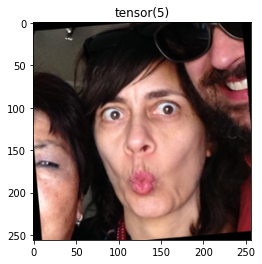

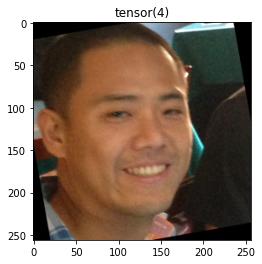

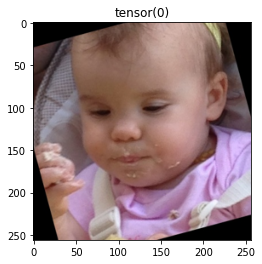

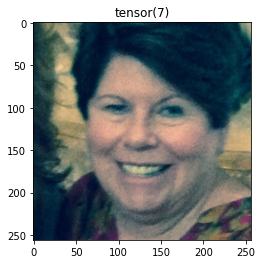

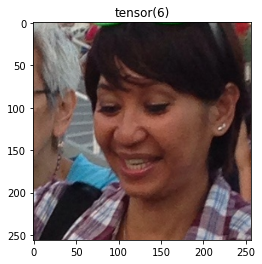

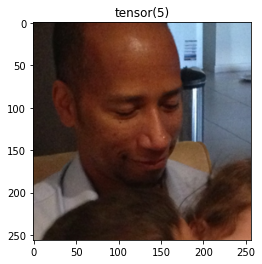

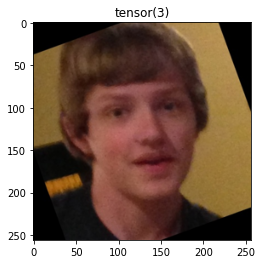

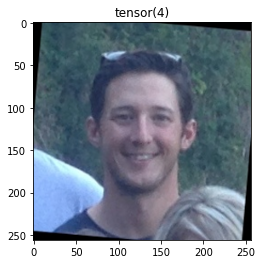

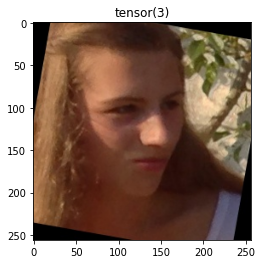

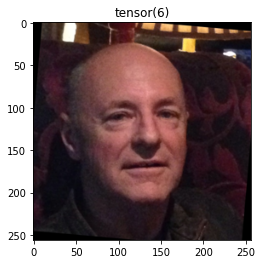

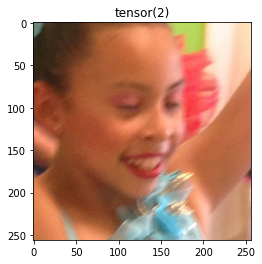

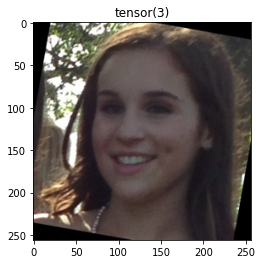

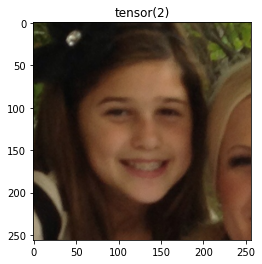

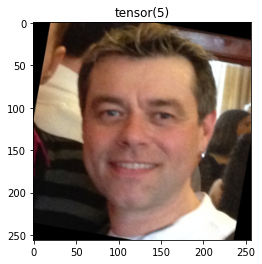

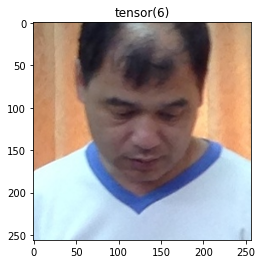

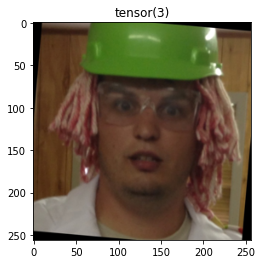

In [25]:
# проверим, что в даталодере всё корректно
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()

X_batch, y_batch = next(iter(train_loader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=y_item)

In [26]:
class AgeGenderNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = torch.nn.BatchNorm2d(num_features=3)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0)
        self.act1  = torch.nn.ELU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # (256-5+1)/2 = 126*126*6 промежуточные рассчеты размера после слоя
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ELU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # (126-5+1)/2 = 61*61*16
        
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=0, stride=2)
        self.act3  = torch.nn.ELU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=32)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # ((61-5)/2+1)/2 = 14*14*32
        
        self.conv4 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0)
        self.act4  = torch.nn.ELU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=32)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # (14-5+1)/2 = 5*5*32=800 - выходной размер при заданных параметрах
        # 
        if dataset1.prediction == 'gender':
            self.fc1   = torch.nn.Linear(32, 2)
        elif dataset1.prediction == 'age':
            self.fc1   = torch.nn.Linear(32, 8)
    
    def forward(self, x):
        x = self.bn0(x)
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.bn4(x)
        x = self.pool4(x)
        
        x = torch.mean(x, dim = (2,3)) # усредняем выходную картинку по ширине и высоте, 
        # это позволит загружать картинки разных размеров и скоратит количество вычислительных операций

        x = self.fc1(x) 
        # softmax не используем, чтобы не нагружать вычислениями
        
        return x

In [54]:
model = AgeGenderNet().float()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # если код запускается на машине c GPU, позволит считать модель на GPU
model = model.to(device)

# датасет не сбалансирован по возрасту, добавим в функцию потерь коэффициенты, учитывающие эту несбалансированность по классам
if dataset1.prediction=='gender':
    loss = torch.nn.CrossEntropyLoss()
elif dataset1.prediction=='age':
    weights = torch.tensor([3.7, 2.5, 2.3, 3, 1, 2, 6, 6])
    loss = torch.nn.CrossEntropyLoss(weight=weights)
    
optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-4, weight_decay = 3.0e-5) #алгоритм Adam, L2-регуляризация

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # каждые 5 эпох уменьшаем learning_rate в 2 раза

In [1]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # в каждой эпохе реализуем train и validation фазы
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()  # для train-фазы ставим модель в train
            else:
                dataloader = test_loader
                model.eval()   # фиксируем модель в фазе валидации 

            running_loss = 0.
            running_acc = 0.

            
            for inputs, labels in tqdm(dataloader): # tqdm для визуализации прогресса вычисления одной эпохи
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # зануляем градиенты, чтобы не накапливались
                # forward и backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    # поскольку softmax не использовался, в качествее предсказания класса берем номер нейрона с наибольшим значением
                    preds_class = preds.argmax(dim=1)  

                    # backward + optimize в фазе train
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # подсчет ошибки и точности для одной эпохи по всем батчам
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader) # делим на количество батчей, чтобы получить усредненную по эпохе ошибку
            epoch_acc = running_acc / len(dataloader) # делим на количество батчей, чтобы получить усредненную по эпохе точность

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


100%|████████████████████████████████████████████████████████████████████████████████| 873/873 [10:58<00:00,  1.33it/s]

train Loss: 1.9471 Acc: 0.2294



100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [01:17<00:00,  2.81it/s]

val Loss: 1.8176 Acc: 0.3102
Epoch 1/9:



100%|████████████████████████████████████████████████████████████████████████████████| 873/873 [10:25<00:00,  1.40it/s]

train Loss: 1.7232 Acc: 0.3286



100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [01:22<00:00,  2.66it/s]

val Loss: 1.6070 Acc: 0.3467
Epoch 2/9:



 17%|█████████████▋                                                                  | 150/873 [01:46<08:45,  1.38it/s]

In [30]:
model.eval()

test_predictions = []
test_img_paths = []
# прогоним обученную модель на тестовых данных
for inputs, labels in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy())

test_predictions = np.concatenate(test_predictions)

100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [01:18<00:00,  2.79it/s]
